In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

import os
import copy
import pandas as pd
import numpy as np
import os
import time
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import torch

# Valid
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
pd.set_option('display.max_rows', 500)

## Import data

In [3]:
path_grab = 'Comp3_suction/suck_apple/bbox'
path_not_grab = 'Comp3_suction/not_suck_apple/bbox'

In [4]:
x_data = []
y_data = []
files_grab = os.listdir(path_grab)
for filename in tqdm(files_grab[:12096]):
    my_dataframe = pd.read_csv(f'{path_grab}\\{filename}', sep=';', header=None)
    temp = []
    for idx in range(7):
        temp.append(my_dataframe[idx][0])
    x_data.append(temp)
    y_data.append([1])

files_not_grab = os.listdir(path_not_grab)
for filename in tqdm(files_not_grab[:len(x_data)]):
    my_dataframe = pd.read_csv(f'{path_not_grab}\\{filename}', sep=';', header=None)
    temp = []
    for idx in range(7):
        temp.append(my_dataframe[idx][0])
    x_data.append(temp)
    y_data.append([0])

  0%|          | 0/12096 [00:00<?, ?it/s]

  0%|          | 0/12096 [00:00<?, ?it/s]

In [5]:
pd_x_data = pd.DataFrame(x_data, columns=['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'velocity_x', 'velocity_y', 'velocity_z'])
pd_y_data = pd.DataFrame(y_data)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(pd_x_data, pd_y_data, test_size=0.4, random_state=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=True)

## Preprocessing

In [7]:
def fit_scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)
    return X_train_scaled, X_test_scaled, scaler

In [8]:
def plot_num_components(X_train_scaled):
    """Plot number of components needed to explain variance"""

    pca = PCA().fit(X_train_scaled)

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, X_train_scaled.shape[1]+1, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')
    print(y)

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, X_train_scaled.shape[1]+1, step=1)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.85, color='r', linestyle='-')
    plt.text(0.5, 0.9, '85% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

In [9]:
X_train_scaled, X_test_scaled, scaler = fit_scale_data(X_train, X_test)

[0.38728373 0.7407287  0.88748076 0.94928334 0.9888575  0.99969315
 1.        ]


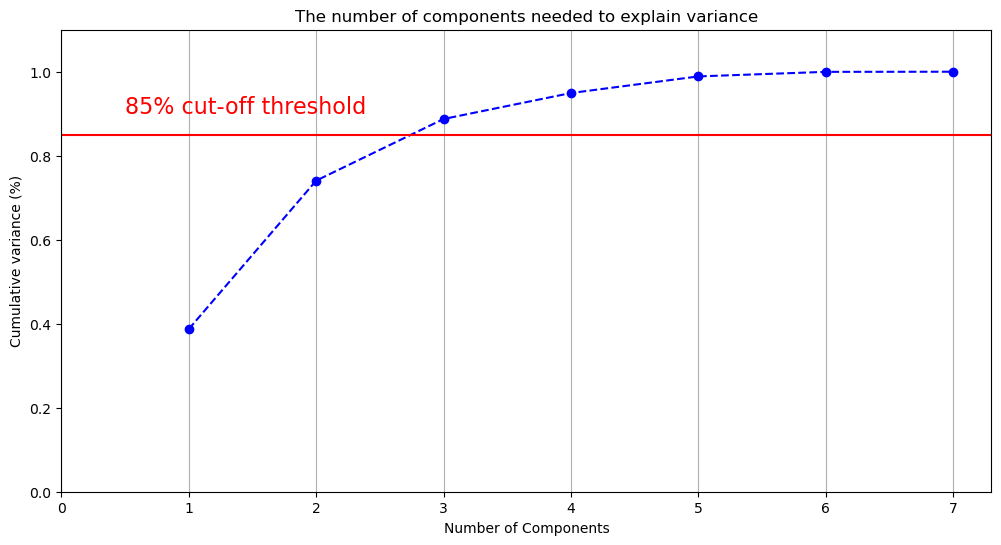

In [10]:
plot_num_components(X_train_scaled)

## Models

#### Machine Learning

In [11]:
def train_machine_learning(model, X_train, y_train, X_test, y_test, X_val=None, y_val=None, print_result=False):
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train) * 100

    test_acc = model.score(X_test, y_test) * 100
    # Confusion Matrix
    pred = model.predict(X_test)
    test_matrix = confusion_matrix(y_test, pred)
    
    val_acc = 0.0
    val_matrix = []
    if X_val is not None:
        val_acc = model.score(X_val, y_val) * 100
        # Confusion Matrix
        pred = model.predict(X_val)
        val_matrix = confusion_matrix(y_val, pred)
    
    if print_result:
        print(f'##### {model} #####')
        print(f'Train accuracy: {train_acc}')
        print(f'Test accuracy: {test_acc}')
        print(f'Test confusion matrix:\n{test_matrix}')
        if X_val is not None:
            print(f'Validate accuracy: {val_acc}')
            print(f'Validate confusion matrix: {val_matrix}')

    return [model, train_acc, test_acc, test_matrix, val_acc, val_matrix]

In [12]:
all_results = []

In [13]:
types = ['ml_pca_scaled', 'ml_pca', 'ml_natural', 'ml_natural_scaled']

for type_train in types:
    #all_results[type_train] = {}
    if type_train in ['ml_pca_scaled', 'ml_pca']:
        len_range = 7
        is_pca = True
    else:
        len_range = 2
        is_pca = False
    for n in range(1, len_range):
        print(f'######## type train: {type_train} - number of component: {n} ########')
        pca = PCA(n_components=n)
        # PCA scaled
        if type_train == 'ml_pca_scaled':
            ml_X_train = pca.fit_transform(X_train_scaled)
            ml_X_test = pca.transform(X_test_scaled)
            ml_X_val = pca.transform(scaler.transform(X_val))
        # PCA
        if type_train == 'ml_pca':
            ml_X_train = pca.fit_transform(X_train)
            ml_X_test = pca.transform(X_test)
            ml_X_val = pca.transform(X_val)
        # Natural
        if type_train == 'ml_natural':
            ml_X_train = X_train.values.tolist()
            ml_X_test = X_test.values.tolist()
            ml_X_val = X_val.values.tolist()
            #ml_X_train = X_train
            #ml_X_test = X_test
            #ml_X_val = X_val
        # Natural scaled
        if type_train == 'ml_natural_scaled':
            ml_X_train = X_train_scaled
            ml_X_test = X_test_scaled
            ml_X_val = scaler.transform(X_val)

        ml_y_train = y_train
        ml_y_test = y_test
        ml_y_val = y_val
        
        # Logistic Regression
        logistic_regression = LogisticRegression()
        all_results.append(train_machine_learning(logistic_regression, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'logistic_regression_{n}')
        all_results[-1].insert(0, type_train)
        
        # SVM
        svc = SVC()
        all_results.append(train_machine_learning(svc, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'svc_{n}')
        all_results[-1].insert(0, type_train)
        
        # Random Forest
        random_forest = RandomForestClassifier()
        all_results.append(train_machine_learning(random_forest, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'random_forest_{n}')
        all_results[-1].insert(0, type_train)
        
        # Naive Bayes
        naive_bayes = GaussianNB() 
        all_results.append(train_machine_learning(naive_bayes, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'naive_bayes_{n}')
        all_results[-1].insert(0, type_train)
        
        # Decision Tree
        decision_tree = DecisionTreeClassifier()
        all_results.append(train_machine_learning(decision_tree, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'decision_tree_{n}')
        all_results[-1].insert(0, type_train)
        
        # K-Nearest Neighbors
        knn = KNeighborsClassifier(n_neighbors = 2)
        all_results.append(train_machine_learning(knn, ml_X_train, ml_y_train, ml_X_test, ml_y_test, ml_X_val, ml_y_val, print_result=True))
        all_results[-1].insert(0, f'knn_{n}')
        all_results[-1].insert(0, type_train)

######## type train: ml_pca_scaled - number of component: 1 ########
##### LogisticRegression() #####
Train accuracy: 32.60764726145367
Test accuracy: 31.91401405539479
Test confusion matrix:
[[1531  862]
 [2432   13]]
Validate accuracy: 32.0934077288696
Validate confusion matrix: [[1533  857]
 [2429   20]]
##### SVC() #####
Train accuracy: 87.79882879779538
Test accuracy: 87.99090533278215
Test confusion matrix:
[[1868  525]
 [  56 2389]]
Validate accuracy: 87.91072535647861
Validate confusion matrix: [[1860  530]
 [  55 2394]]
##### RandomForestClassifier() #####
Train accuracy: 99.97933172580089
Test accuracy: 83.21620504340636
Test confusion matrix:
[[1998  395]
 [ 417 2028]]
Validate accuracy: 83.09568092581112
Validate confusion matrix: [[1969  421]
 [ 397 2052]]
##### GaussianNB() #####
Train accuracy: 88.34309335170514
Test accuracy: 88.59032658123192
Test confusion matrix:
[[1904  489]
 [  63 2382]]
Validate accuracy: 88.15871047737136
Validate confusion matrix: [[1895  495]
 

##### KNeighborsClassifier(n_neighbors=2) #####
Train accuracy: 98.7323458491216
Test accuracy: 95.59735427862753
Test confusion matrix:
[[2311   82]
 [ 131 2314]]
Validate accuracy: 95.86691465178757
Validate confusion matrix: [[2302   88]
 [ 112 2337]]
######## type train: ml_pca - number of component: 1 ########
##### LogisticRegression() #####
Train accuracy: 41.30899069927661
Test accuracy: 39.89251756924349
Test confusion matrix:
[[1930  463]
 [2445    0]]
Validate accuracy: 40.524901839222984
Validate confusion matrix: [[1961  429]
 [2449    0]]
##### SVC() #####
Train accuracy: 89.61763692731657
Test accuracy: 89.66515088879702
Test confusion matrix:
[[1932  461]
 [  39 2406]]
Validate accuracy: 89.64662120272784
Validate confusion matrix: [[1929  461]
 [  40 2409]]
##### RandomForestClassifier() #####
Train accuracy: 99.59352394075096
Test accuracy: 86.4406779661017
Test confusion matrix:
[[2074  319]
 [ 337 2108]]
Validate accuracy: 86.79479231246125
Validate confusion matrix

##### RandomForestClassifier() #####
Train accuracy: 100.0
Test accuracy: 97.912360479537
Test confusion matrix:
[[2305   88]
 [  13 2432]]
Validate accuracy: 97.62347592477785
Validate confusion matrix: [[2292   98]
 [  17 2432]]
##### GaussianNB() #####
Train accuracy: 90.56148811574234
Test accuracy: 90.57461761058289
Test confusion matrix:
[[2024  369]
 [  87 2358]]
Validate accuracy: 90.41124199214714
Validate confusion matrix: [[2023  367]
 [  97 2352]]
##### DecisionTreeClassifier() #####
Train accuracy: 100.0
Test accuracy: 96.65150888797024
Test confusion matrix:
[[2304   89]
 [  73 2372]]
Validate accuracy: 96.011572638975
Validate confusion matrix: [[2298   92]
 [ 101 2348]]
##### KNeighborsClassifier(n_neighbors=2) #####
Train accuracy: 98.8701343437823
Test accuracy: 96.2381149235221
Test confusion matrix:
[[2318   75]
 [ 107 2338]]
Validate accuracy: 96.42488117379624
Validate confusion matrix: [[2308   82]
 [  91 2358]]
######## type train: ml_natural - number of compone

#### Dense

In [14]:
def create_model(input_size):
    model = torch.nn.Sequential (
            torch.nn.Linear(in_features=input_size, out_features=128),    # Camada densa com entrada de 30 e saída de 16
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
            #torch.nn.Softmax(dim=1)    # dim=0 = Soma de cada coluna é 1 e dim=1 = somada de cada linha é 1
            )
    criterion = torch.nn.BCELoss()                   # Cria Binary Cross Entropy (loss)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Cria otimizador (Adam) para rede
    return model, criterion, optimizer

In [15]:
new_y_train = []
new_y_test = []
new_y_val = []
for value in list(y_train[0]):
    new_y_train.append([value])
for value in list(y_test[0]):
    new_y_test.append([value])
for value in list(y_val[0]):
    new_y_val.append([value])

In [16]:
types = ['dense_pca_scaled', 'dense_pca', 'dense_natural', 'dense_natural_scaled']
#types = ['dense_natural_scaled5']
for t in types:
    type_train = t
    #all_results[type_train] = {}
    if type_train in ['dense_pca_scaled', 'dense_pca']:
        len_range = 7
        is_pca = True
    else:
        len_range = 2
        is_pca = False
    for n in range(1, len_range):
        print(f'######## type train: {type_train} - number of component: {n} ########')
        pca = PCA(n_components=n)
        # PCA scaled
        if type_train == 'dense_pca_scaled':
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            X_val_pca = pca.transform(scaler.transform(X_val))
        # PCA
        if type_train == 'dense_pca':
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
            X_val_pca = pca.transform(X_val)
        # Natural
        if type_train == 'dense_natural':
            X_train_pca = X_train.values.tolist()
            X_test_pca = X_test.values.tolist()
            X_val_pca = X_val.values.tolist()
        # Natural scaled
        if type_train == 'dense_natural_scaled':
            X_train_pca = X_train_scaled
            X_test_pca = X_test_scaled
            X_val_pca = scaler.transform(X_val)

        tensor_X_train = torch.Tensor(X_train_pca)
        tensor_y_train = torch.Tensor(new_y_train)
        tensor_X_test = torch.Tensor(X_test_pca)
        tensor_y_test = torch.Tensor(new_y_test)
        tensor_X_val = torch.Tensor(X_val_pca)
        tensor_y_val = torch.Tensor(new_y_val)

        dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        if is_pca:
            model, criterion, optimizer = create_model(input_size=n)
        else:
            model, criterion, optimizer = create_model(input_size=7)

        best_acc_test = 0.
        best_model = None
        for epoch in tqdm(range(300)):
            running_loss = 0.
            model.train()
            for data in train_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                p = outputs.cpu().detach().numpy()
                p = p >= 0.5
                acc_train = accuracy_score(labels, p)
            #print('Epoch {}; Loss {}'.format(epoch, running_loss/len(train_loader)))
            if epoch % 5 == 0:
                model.eval()
                tensor_X_test = tensor_X_test.to(device)
                previsoes = model(tensor_X_test)
                p = previsoes.cpu().detach().numpy()
                p = p >= 0.5
                acc = accuracy_score(y_test, p)
                if acc > best_acc_test:
                    #print('Best model')
                    best_model = copy.deepcopy(model)
                    
                    best_acc_test = acc
                    best_confusion_matrix_test = confusion_matrix(y_test, p)
                    
                    tensor_X_val = tensor_X_val.to(device)
                    previsoes = model(tensor_X_val)
                    p = previsoes.cpu().detach().numpy()
                    p = p >= 0.5
                    acc = accuracy_score(y_val, p)
                    best_acc_val = acc
                    best_confusion_matrix_val = confusion_matrix(y_val, p)
                    print(f'Accuracy: {best_acc_test}')
        all_results.append([type_train, f'dense_{n}', best_model, acc_train*100, best_acc_test*100, best_confusion_matrix_test, best_acc_val*100, best_confusion_matrix_val])

######## type train: dense_pca_scaled - number of component: 1 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8486978090119884
Accuracy: 0.8873501446878875
######## type train: dense_pca_scaled - number of component: 2 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.854071930549814
Accuracy: 0.9082265398925176
Accuracy: 0.9105002066969822
Accuracy: 0.9111202976436544
Accuracy: 0.9113269946258785
Accuracy: 0.9119470855725507
Accuracy: 0.912980570483671
Accuracy: 0.913187267465895
Accuracy: 0.913393964448119
######## type train: dense_pca_scaled - number of component: 3 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.892104175279041
Accuracy: 0.9276560562215792
Accuracy: 0.9384042992972302
Accuracy: 0.9415047540305912
Accuracy: 0.944605208763952
Accuracy: 0.9454319966928483
Accuracy: 0.9468788755684167
Accuracy: 0.9477056634973129
Accuracy: 0.9487391484084332
Accuracy: 0.9510128152128979
Accuracy: 0.9518396031417942
Accuracy: 0.9539065729640347
Accuracy: 0.954940057875155
Accuracy: 0.9559735427862753
Accuracy: 0.9563869367507234
Accuracy: 0.9574204216618437
Accuracy: 0.9578338156262919
Accuracy: 0.9588673005374122
Accuracy: 0.9594873914840844
Accuracy: 0.9615543613063249
Accuracy: 0.9632079371641175
Accuracy: 0.9640347250930137
######## type train: dense_pca_scaled - number of component: 4 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8941711451012815
Accuracy: 0.9365440264572137
Accuracy: 0.9464654816039686
Accuracy: 0.9516329061595701
Accuracy: 0.9547333608929309
Accuracy: 0.9563869367507234
Accuracy: 0.9568003307151716
Accuracy: 0.9574204216618437
Accuracy: 0.9576271186440678
Accuracy: 0.9601074824307565
Accuracy: 0.9607275733774286
Accuracy: 0.961761058288549
Accuracy: 0.9621744522529971
Accuracy: 0.9625878462174452
Accuracy: 0.9634146341463414
Accuracy: 0.9638280281107896
Accuracy: 0.9640347250930137
Accuracy: 0.9642414220752377
Accuracy: 0.9658949979330301
Accuracy: 0.9663083918974783
Accuracy: 0.9671351798263745
Accuracy: 0.9673418768085986
######## type train: dense_pca_scaled - number of component: 5 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8912773873501447
Accuracy: 0.9417114510128152
Accuracy: 0.9555601488218272
Accuracy: 0.9588673005374122
Accuracy: 0.9621744522529971
Accuracy: 0.9623811492352211
Accuracy: 0.9634146341463414
Accuracy: 0.9644481190574618
Accuracy: 0.9648615130219099
Accuracy: 0.9654816039685821
Accuracy: 0.9669284828441504
Accuracy: 0.9681686647374949
Accuracy: 0.9694088466308391
Accuracy: 0.9702356345597354
Accuracy: 0.9704423315419595
Accuracy: 0.9706490285241836
Accuracy: 0.9710624224886316
Accuracy: 0.9712691194708557
Accuracy: 0.9714758164530798
Accuracy: 0.9718892104175278
Accuracy: 0.9720959073997519
Accuracy: 0.9725093013642001
######## type train: dense_pca_scaled - number of component: 6 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.9113269946258785
Accuracy: 0.9572137246796196
Accuracy: 0.9640347250930137
Accuracy: 0.9679619677552708
Accuracy: 0.9702356345597354
Accuracy: 0.9735427862753204
Accuracy: 0.975816453079785
Accuracy: 0.9770566349731294
Accuracy: 0.9776767259198016
Accuracy: 0.9780901198842497
Accuracy: 0.9782968168664737
Accuracy: 0.9785035138486978
Accuracy: 0.9787102108309219
Accuracy: 0.97912360479537
Accuracy: 0.9793303017775941
Accuracy: 0.9797436957420421
Accuracy: 0.9799503927242662
Accuracy: 0.9801570897064903
Accuracy: 0.9803637866887144
Accuracy: 0.9811905746176106
Accuracy: 0.9813972715998347
######## type train: dense_pca - number of component: 1 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8344357172385283
Accuracy: 0.8596527490698636
Accuracy: 0.8873501446878875
Accuracy: 0.8968582058701943
Accuracy: 0.9042992972302605
Accuracy: 0.9092600248036379
Accuracy: 0.909466721785862
Accuracy: 0.9113269946258785
Accuracy: 0.9115336916081025
Accuracy: 0.9119470855725507
######## type train: dense_pca - number of component: 2 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.7598181066556429
Accuracy: 0.8753617197188921
Accuracy: 0.8985117817279867
Accuracy: 0.9076064489458454
Accuracy: 0.9105002066969822
Accuracy: 0.9142207523770153
Accuracy: 0.9160810252170318
Accuracy: 0.916701116163704
Accuracy: 0.9169078131459281
Accuracy: 0.9175279040926002
######## type train: dense_pca - number of component: 3 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8176932616783795
Accuracy: 0.8976849937990905
Accuracy: 0.9280694501860273
Accuracy: 0.9437784208350558
Accuracy: 0.9454319966928483
Accuracy: 0.9489458453906573
Accuracy: 0.9512195121951219
Accuracy: 0.9522529971062422
Accuracy: 0.9551467548573791
Accuracy: 0.9563869367507234
Accuracy: 0.9570070276973957
Accuracy: 0.9572137246796196
Accuracy: 0.9574204216618437
Accuracy: 0.9609342703596527
######## type train: dense_pca - number of component: 4 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8195535345183961
Accuracy: 0.9049193881769326
Accuracy: 0.9330301777594047
Accuracy: 0.9381976023150062
Accuracy: 0.9503927242662257
Accuracy: 0.951426209177346
Accuracy: 0.9518396031417942
Accuracy: 0.954526663910707
Accuracy: 0.9553534518396032
Accuracy: 0.9555601488218272
Accuracy: 0.9568003307151716
Accuracy: 0.95824720959074
Accuracy: 0.9586606035551881
Accuracy: 0.9592806945018603
Accuracy: 0.9594873914840844
Accuracy: 0.9599007854485324
Accuracy: 0.9601074824307565
Accuracy: 0.961967755270773
######## type train: dense_pca - number of component: 5 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8303017775940471
Accuracy: 0.9226953286482017
Accuracy: 0.9346837536171972
Accuracy: 0.944398511781728
Accuracy: 0.9495659363373294
Accuracy: 0.9534931789995866
Accuracy: 0.9539065729640347
Accuracy: 0.9553534518396032
Accuracy: 0.958453906572964
Accuracy: 0.9588673005374122
Accuracy: 0.9609342703596527
Accuracy: 0.961761058288549
Accuracy: 0.9627945431996693
Accuracy: 0.9632079371641175
Accuracy: 0.9634146341463414
Accuracy: 0.9642414220752377
Accuracy: 0.9644481190574618
Accuracy: 0.9650682100041339
Accuracy: 0.9654816039685821
######## type train: dense_pca - number of component: 6 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.8431169904919388
Accuracy: 0.9260024803637867
Accuracy: 0.9437784208350558
Accuracy: 0.9512195121951219
Accuracy: 0.9605208763952047
Accuracy: 0.9648615130219099
Accuracy: 0.9661016949152542
Accuracy: 0.9696155436130632
Accuracy: 0.9700289375775114
Accuracy: 0.9702356345597354
Accuracy: 0.9712691194708557
Accuracy: 0.9714758164530798
Accuracy: 0.9718892104175278
Accuracy: 0.9720959073997519
Accuracy: 0.9739561802397685
######## type train: dense_natural - number of component: 1 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.833195535345184
Accuracy: 0.8896238114923523
Accuracy: 0.8999586606035552
Accuracy: 0.9156676312525837
Accuracy: 0.9204216618437371
Accuracy: 0.9251756924348904
Accuracy: 0.9313766019016122
Accuracy: 0.9322033898305084
Accuracy: 0.9350971475816453
Accuracy: 0.9394377842083506
Accuracy: 0.9417114510128152
Accuracy: 0.9450186027284002
Accuracy: 0.9456386936750724
Accuracy: 0.9477056634973129
Accuracy: 0.9489458453906573
Accuracy: 0.9499793303017776
Accuracy: 0.9539065729640347
Accuracy: 0.954526663910707
Accuracy: 0.9572137246796196
Accuracy: 0.95824720959074
Accuracy: 0.9605208763952047
Accuracy: 0.9656883009508062
Accuracy: 0.9689954526663911
######## type train: dense_natural_scaled - number of component: 1 ########


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy: 0.913393964448119
Accuracy: 0.961761058288549
Accuracy: 0.9727159983464242
Accuracy: 0.9778834229020257
Accuracy: 0.97912360479537
Accuracy: 0.9797436957420421
Accuracy: 0.9803637866887144
Accuracy: 0.9809838776353865
Accuracy: 0.9820173625465068
Accuracy: 0.982637453493179
Accuracy: 0.9832575444398511
Accuracy: 0.9840843323687474
Accuracy: 0.9844977263331955
Accuracy: 0.9853245142620918
Accuracy: 0.9855312112443159


In [17]:
all_results_df = pd.DataFrame(all_results, columns=['type_train', 'algorithm', 'model', 'train_acc', 'test_acc', 'test_matrix', 'val_acc', 'val_matrix'])

In [18]:
all_results_df.to_csv('Comp3_suction/all_results.csv', index=False)

### Analysis trainning data

In [19]:
#all_results_df = pd.read_csv('Comp3_suction/all_results.csv')

In [20]:
# Dense
all_results_df[84:].sort_values(by='val_acc', ascending=False)

,type_train,algorithm,model,train_acc,test_acc,test_matrix,val_acc,val_matrix
97,dense_natural_scaled,dense_1,"[Linear(in_features=7, out_features=128, bias=...",1.000000,98.553121,"[[2335, 58], [12, 2433]]",98.346766,"[[2322, 68], [12, 2437]]"
89,dense_pca_scaled,dense_6,"[Linear(in_features=6, out_features=128, bias=...",0.960784,98.139727,"[[2309, 84], [6, 2439]]",97.850796,"[[2294, 96], [8, 2441]]"
95,dense_pca,dense_6,"[Linear(in_features=6, out_features=128, bias=...",1.000000,97.395618,"[[2293, 100], [26, 2419]]",97.292829,"[[2278, 112], [19, 2430]]"
88,dense_pca_scaled,dense_5,"[Linear(in_features=5, out_features=128, bias=...",0.980392,97.250930,"[[2292, 101], [32, 2413]]",96.941517,"[[2283, 107], [41, 2408]]"
96,dense_natural,dense_1,"[Linear(in_features=7, out_features=128, bias=...",1.000000,96.899545,"[[2266, 127], [23, 2422]]",96.672866,"[[2251, 139], [22, 2427]]"
94,dense_pca,dense_5,"[Linear(in_features=5, out_features=128, bias=...",0.941176,96.548160,"[[2249, 144], [23, 2422]]",96.424881,"[[2238, 152], [21, 2428]]"
87,dense_pca_scaled,dense_4,"[Linear(in_features=4, out_features=128, bias=...",0.980392,96.734188,"[[2269, 124], [34, 2411]]",96.404216,"[[2259, 131], [43, 2406]]"
93,dense_pca,dense_4,"[Linear(in_features=4, out_features=128, bias=...",0.980392,96.196776,"[[2259, 134], [50, 2395]]",96.011573,"[[2248, 142], [51, 2398]]"
92,dense_pca,dense_3,"[Linear(in_features=3, out_features=128, bias=...",0.921569,96.093427,"[[2252, 141], [48, 2397]]",95.908246,"[[2236, 154], [44, 2405]]"
86,dense_pca_scaled,dense_3,"[Linear(in_features=3, out_features=128, bias=...",0.980392,96.403473,"[[2253, 140], [34, 2411]]",95.577599,"[[2239, 151], [63, 2386]]"


In [21]:
# Machine Learning
all_results_df[:84].sort_values(by='val_acc', ascending=False)

,type_train,algorithm,model,train_acc,test_acc,test_matrix,val_acc,val_matrix
80,ml_natural_scaled,random_forest_1,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,98.408433,"[[2332, 61], [16, 2429]]",98.367431,"[[2321, 69], [10, 2439]]"
74,ml_natural,random_forest_1,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,98.429103,"[[2336, 57], [19, 2426]]",98.326100,"[[2320, 70], [11, 2438]]"
68,ml_pca,random_forest_6,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.912360,"[[2305, 88], [13, 2432]]",97.623476,"[[2292, 98], [17, 2432]]"
32,ml_pca_scaled,random_forest_6,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.457627,"[[2288, 105], [18, 2427]]",97.189502,"[[2277, 113], [23, 2426]]"
62,ml_pca,random_forest_5,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.250930,"[[2289, 104], [29, 2416]]",97.148171,"[[2285, 105], [33, 2416]]"
82,ml_natural_scaled,decision_tree_1,DecisionTreeClassifier(),100.000000,97.064903,"[[2327, 66], [76, 2369]]",96.962182,"[[2315, 75], [72, 2377]]"
76,ml_natural,decision_tree_1,DecisionTreeClassifier(),100.000000,96.878876,"[[2324, 69], [82, 2363]]",96.776193,"[[2315, 75], [81, 2368]]"
56,ml_pca,random_forest_4,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,96.961554,"[[2285, 108], [39, 2406]]",96.776193,"[[2273, 117], [39, 2410]]"
26,ml_pca_scaled,random_forest_5,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.002894,"[[2274, 119], [26, 2419]]",96.714197,"[[2265, 125], [34, 2415]]"
77,ml_natural,knn_1,KNeighborsClassifier(n_neighbors=2),99.021702,96.630839,"[[2325, 68], [95, 2350]]",96.507543,"[[2316, 74], [95, 2354]]"


In [59]:
# All
all_results_df.sort_values(by='val_acc', ascending=False)

,type_train,algorithm,model,train_acc,test_acc,test_matrix,val_acc,val_matrix
80,ml_natural_scaled,random_forest_1,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,98.408433,"[[2332, 61], [16, 2429]]",98.367431,"[[2321, 69], [10, 2439]]"
97,dense_natural_scaled,dense_1,"[Linear(in_features=7, out_features=128, bias=...",1.000000,98.553121,"[[2335, 58], [12, 2433]]",98.346766,"[[2322, 68], [12, 2437]]"
74,ml_natural,random_forest_1,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,98.429103,"[[2336, 57], [19, 2426]]",98.326100,"[[2320, 70], [11, 2438]]"
89,dense_pca_scaled,dense_6,"[Linear(in_features=6, out_features=128, bias=...",0.960784,98.139727,"[[2309, 84], [6, 2439]]",97.850796,"[[2294, 96], [8, 2441]]"
68,ml_pca,random_forest_6,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.912360,"[[2305, 88], [13, 2432]]",97.623476,"[[2292, 98], [17, 2432]]"
95,dense_pca,dense_6,"[Linear(in_features=6, out_features=128, bias=...",1.000000,97.395618,"[[2293, 100], [26, 2419]]",97.292829,"[[2278, 112], [19, 2430]]"
32,ml_pca_scaled,random_forest_6,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.457627,"[[2288, 105], [18, 2427]]",97.189502,"[[2277, 113], [23, 2426]]"
62,ml_pca,random_forest_5,"(DecisionTreeClassifier(max_features='auto', r...",100.000000,97.250930,"[[2289, 104], [29, 2416]]",97.148171,"[[2285, 105], [33, 2416]]"
82,ml_natural_scaled,decision_tree_1,DecisionTreeClassifier(),100.000000,97.064903,"[[2327, 66], [76, 2369]]",96.962182,"[[2315, 75], [72, 2377]]"
88,dense_pca_scaled,dense_5,"[Linear(in_features=5, out_features=128, bias=...",0.980392,97.250930,"[[2292, 101], [32, 2413]]",96.941517,"[[2283, 107], [41, 2408]]"


#### Test processing time

In [22]:
def get_model(type_train, algorithm):
    res1 = all_results_df[all_results_df['type_train']==type_train]
    return list(res1[res1['algorithm']==algorithm]['model'])[0]

In [46]:
model = get_model('ml_natural', 'random_forest_1')

all_time = 0
for n in range(20):
    tic = time.time()
    model.predict([X_train.values.tolist()[0]])
    all_time += time.time() - tic
print(all_time/20)

0.02754765748977661


In [42]:
model = get_model('ml_natural_scaled', 'random_forest_1')

all_time = 0
for n in range(20):
    tic = time.time()
    model.predict(scaler.transform([X_train.values.tolist()[0]]))
    all_time += time.time() - tic
print(all_time/20)

0.027847027778625487


In [35]:
model = get_model('dense_natural_scaled', 'dense_1')

all_time = 0
for n in range(20):
    tic = time.time()
    tensor_X_train = torch.Tensor(scaler.transform([X_train.values.tolist()[0]]))
    model(tensor_X_train)
    all_time += time.time() - tic
print(all_time/20)

0.013449430465698242


In [54]:
pca = PCA(n_components=6)
# To simulate time processing
pca.fit(X_train_scaled)
model = get_model('ml_pca', 'random_forest_6')

all_time = 0
for n in range(20):
    tic = time.time()
    model.predict(pca.transform([X_train.values.tolist()[0]]))
    all_time += time.time() - tic
print(all_time/20)

0.02797185182571411


In [58]:
pca = PCA(n_components=2)
# To simulate time processing
pca.fit(X_train_scaled)
model = get_model('ml_pca', 'random_forest_2')

all_time = 0
for n in range(20):
    tic = time.time()
    model.predict(pca.transform([X_train.values.tolist()[0]]))
    all_time += time.time() - tic
print(all_time/20)

0.027797114849090577


In [29]:
torch.save(get_model('dense_natural_scaled', 'dense_1'), 'Comp3_suction/suction_network.pth')

In [30]:
from joblib import dump, load
dump(scaler, 'Comp3_suction/suction_std_scaler.bin', compress=True)
#sc=load('std_scaler.bin')

['std_scaler.bin']

### Analysis enviroment

In [2]:
import pandas as pd

In [3]:
all_results_df = pd.read_csv('Comp3_suction/result_env1_suction.csv', sep=';')

In [8]:
# Remove low FPS and fails
all_results_df_filtred = all_results_df[all_results_df['mean_fps'] > 5.0]
all_results_df_filtred = all_results_df_filtred[all_results_df_filtred['last_reward'] > 600]

In [9]:
all_results_df_filtred.describe()

,episode,steps,steps_try_grab_apple,current_exploration,time,mean_time,mean_fps,reward,last_reward,last_code_grab_overlap,last_code_arm_collision
count,84.000000,84.000000,84.000000,8.400000e+01,84.000000,84.000000,84.000000,84.000000,84.000000,84.0,84.0
mean,48.940476,40.190476,6.071429,3.500000e-01,6.388295,0.159053,6.300324,950.081442,936.471424,21001.0,10000.0
std,28.614324,3.825961,2.063952,1.116891e-16,0.637154,0.007650,0.277116,17.782277,17.875048,0.0,0.0
min,0.000000,31.000000,3.000000,3.500000e-01,4.713525,0.150077,5.065697,867.523748,851.966763,21001.0,10000.0
25%,25.750000,37.000000,5.000000,3.500000e-01,5.894776,0.154086,6.247700,945.186389,932.499549,21001.0,10000.0
50%,49.500000,40.000000,6.000000,3.500000e-01,6.434998,0.156646,6.383817,954.785766,941.595289,21001.0,10000.0
75%,73.250000,43.000000,7.000000,3.500000e-01,6.783085,0.160059,6.489896,959.575718,944.934019,21001.0,10000.0
max,98.000000,50.000000,13.000000,3.500000e-01,7.983800,0.197406,6.663257,976.963031,962.961703,21001.0,10000.0


In [10]:
# Remove low FPS and get fails
all_results_df_filtred2 = all_results_df[all_results_df['mean_fps'] > 5.0]
all_results_df_filtred2 = all_results_df_filtred2[all_results_df_filtred2['last_reward'] < 600]

In [13]:
# Looks like, lost sight of the apple
all_results_df_filtred2[all_results_df_filtred2['steps_try_grab_apple']!=0]

,episode,steps,steps_try_grab_apple,initial_position_apple,current_exploration,time,mean_time,mean_fps,reward,last_reward,last_code_grab_overlap,last_code_arm_collision,last_drone_collision,last_action,last_state
6,6,37,5,"(1.2684968709945679, 0.18498648703098297, -1.8...",0.35,5.641759,0.152480,6.558239,-90.561519,-99.928785,11001,10002,False,"(0.05062127113342285, 0.03155709430575371, -0....","{'bbox': [0.5207334756851196, 0.58067825105455..."
20,20,38,6,"(1.3090800046920776, 0.14342738687992096, -2.1...",0.35,5.872320,0.154535,6.471037,-89.695944,-99.530147,21001,10002,False,"(0.04804603382945061, -0.09778951108455658, -0...","{'bbox': [0.5231158137321472, 0.58367813958062..."
22,22,39,4,"(1.3184025287628174, 0.25828391313552856, -2.2...",0.35,6.694255,0.171648,5.825891,-88.248349,-100.115613,11001,10002,False,"(0.09581232520328412, -0.05631809217306179, -0...","{'bbox': [0.4481830298900604, 0.58228407965766..."
46,46,46,5,"(1.3265211582183838, -0.035350263118743896, -2...",0.35,7.369968,0.160217,6.241547,-90.019586,-100.271460,21001,10002,False,"(0.043173689793609096, 0.011610049237281414, -...","{'bbox': [0.45113155245780945, 0.5838413238525..."
61,61,47,5,"(1.3930672407150269, -0.26949232816696167, -1....",0.35,8.254783,0.175634,5.693668,-86.938954,-100.100131,11001,10002,False,"(0.06695161759853363, -0.00998787209391594, -0...","{'bbox': [0.451282799243927, 0.586145665910508..."
63,63,38,5,"(1.2386752367019653, 0.22301921248435974, -1.9...",0.35,6.168256,0.162323,6.160575,-90.603371,-100.232534,21001,10002,False,"(0.10812443174232726, 0.02400651763229876, -0....","{'bbox': [0.44904741644859314, 0.5880482991536..."
75,75,44,4,"(1.3985798358917236, 0.28765812516212463, -2.0...",0.35,6.745157,0.153299,6.523199,-87.799296,-99.924123,11001,10002,False,"(0.05085616558790207, 0.038173265755176544, -0...","{'bbox': [0.5214414000511169, 0.59196016523573..."
99,99,36,7,"(1.263067603111267, -0.5229406356811523, -2.03...",0.35,5.743065,0.159530,6.268430,-86.608754,-100.166722,21001,10002,False,"(0.09189823235229418, -0.036093896785763, -0.2...","{'bbox': [0.45405927300453186, 0.5737519794040..."
